<a href="https://colab.research.google.com/github/Princewyl/models/blob/housing_predictor/Housing_Value_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.6104 - precision: 0.3809 - recall: 0.8952 - auc: 0.8315
Epoch 2/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4981 - accuracy: 0.6479 - precision: 0.4047 - recall: 0.8691 - auc: 0.8340
Epoch 3/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.6870 - precision: 0.4339 - recall: 0.8305 - auc: 0.8357
Epoch 4/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7196 - precision: 0.4641 - recall: 0.7923 - auc: 0.8364
Epoch 5/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.7426 - precision: 0.4902 - recall: 0.7514 - auc: 0.8365
Epoch 6/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.7651 - precision: 0.5218 - recall: 0.7130 - auc: 0.8368
Epoch 7/50
170/170 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.7824 - pre

30/30 [==============================] - 1s 2ms/step - loss: 0.4069 - accuracy: 0.8020 - precision: 0.6030 - recall: 0.5965 - auc: 0.8265


[0.40689021348953247,
 0.8019999861717224,
 0.6029810309410095,
 0.5965147614479065,
 0.8264786005020142]

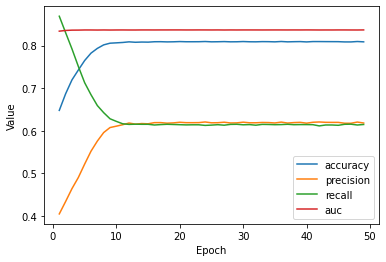

In [ ]:
from tensorflow.python.ops.math_ops import sigmoid
"""This predicts the Median House Value using the California Data Set"""
#load imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#adjust the granularity of reporting
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

#load the datasets from the internet
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
# shuffle the training set
train_df = train_df.reindex(np.random.permutation(train_df.index)) 

#normalize values using z score
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

#create binary labels, first get math info of data
threshold = 265000 #75th percentile for median house value
train_df_norm['median_house_value_is_high'] = (train_df['median_house_value'] > threshold).astype(float)
test_df_norm['median_house_value_is_high'] = (test_df['median_house_value'] > threshold).astype(float)
train_df_norm['median_house_value_is_high'].head(8000)

#create feature columns and represent meian income and total rooms
#in numeric column
feature_columns = []
median_income = tf.feature_column.numeric_column('median_income')
feature_columns.append(median_income)

tr = tf.feature_column.numeric_column('total_rooms')
feature_columns.append(tr)

feature_layer = layers.DenseFeatures(feature_columns)

#define functions that create and train the model
def create_model(my_learning_rate, feature_layer, my_metrics):
  #using a sequential model
  model = tf.keras.models.Sequential()
  #add feature layer to model
  model.add(feature_layer)
  #funnel the regression value through a sigmoid function
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), 
                                  activation=tf.sigmoid),)
  #call the compile method to construct the layers in a model that can be executed
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate), 
                loss=tf.keras.losses.BinaryCrossentropy(), metrics=my_metrics)
  return model

def train_model(model, dataset, epochs, label_name, batch_size=None, 
                shuffle=True):
  #feed data set into model to train it
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size, 
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist

#define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Value')

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

  #invoke the create, train and plotting functions. first list hypeparameters
  #then establish the metrics the model will measure, establish topography,
  #train model, and finally plot graph
learning_rate = 0.001
epochs = 50
batch_size = 100
label_name = 'median_house_value_is_high'
classification_threshold = 0.35

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold), 
    tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ), 
    tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"), 
    tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

my_model = create_model(learning_rate, feature_layer, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, 
                             batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc']

plot_curve(epochs, hist, list_of_metrics_to_plot)

#evaluate the model against the test set
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x=features, y=label, batch_size=batch_size)